In [1]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prfs
import skimage.io as io
from collections import defaultdict

# UNet imports
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.nn.functional import relu

from torch.autograd import Variable

# Custom imports

# tany
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm import tqdm
import random
import logging
import datetime
from tensorboardX import SummaryWriter
# import metrics
import gc
from pathlib import Path



In [2]:
!rm -rf /kaggle/working/*

In [3]:
# create output folders
Path('/kaggle/working/images').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/labels').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/models').mkdir(parents=True, exist_ok=True)

In [4]:
# initialize cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## ***Deep Learning Methods***

1. UNet
2. Siamese
3. SUNet

### **UNet**

UNet Architecture
1. Encoder (Contracting Path): down sampling the input image size while depth increases

    Each Block:
    - Two 3*3 Convolutional Layers zero-padded with stride=1 Each Followed by a RELU Activation
    - Max Pooling Layer 2*2 with stride=2 (Dimension halved)(Same Depth) [⬇ Down Sampling] 

2. Decoder

### **Siamese UNet**

1. Load the dataset using dataloaders

In [5]:
class LoadDataset(Dataset):
    def __init__(self, input_folder, transforms_list=[]):
        
        self.before_folder = os.path.join(input_folder, 'A')
        self.after_folder = os.path.join(input_folder, 'B')
        self.label_folder = os.path.join(input_folder, 'label')

        self.file_names = os.listdir(self.before_folder) # any folder msh far2a

        self.transforms = transforms_list
        
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        before_image = io.imread(os.path.join(self.before_folder, self.file_names[idx]))
        after_image = io.imread(os.path.join(self.before_folder, self.file_names[idx]))
        label = io.imread(os.path.join(self.label_folder, self.file_names[idx]))

        
        label = label.astype('float32')  # Convert to floating point to allow division
        label = label > 0
        label = label.astype(np.int64)
        label = torch.as_tensor(label, dtype=torch.float32)
        label = label.squeeze()

        if len(self.transforms) == 2:
            before_image = self.transforms[0](before_image)
            after_image = self.transforms[1](after_image)


        return {'images': (before_image, after_image), 'label': label}
    
# Define the transformations
transform = [transforms.Compose([transforms.ToTensor()]), transforms.Compose([transforms.ToTensor()])]

# Load the dataset
dataset = LoadDataset('/kaggle/input/sat-dataset/trainval', transform)

# Split the dataset into training, test, and validation sets (80, 10, 10)
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
# val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# create the DataLoader
dataloader = {
    'train': DataLoader(train_set, batch_size=16, shuffle=True),
#     'val': DataLoader(val_set, batch_size=16, shuffle=False),
    'test': DataLoader(test_set, batch_size=16, shuffle=False)
}

print("DATASET LOADED")

DATASET LOADED


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            # N,C,H,W => N,C,H*W
            input = input.view(input.size(0), input.size(1), -1)

            # N,C,H*W => N,H*W,C
            input = input.transpose(1, 2)

            # N,H*W,C => N*H*W,C
            input = input.contiguous().view(-1, input.size(2))


        target = target.view(-1, 1)
        logpt = F.log_softmax(input,dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

def dice_loss(logits, true, positive_weight=1, eps=1e-7):
    """Computes the Sørensen–Dice loss with weighted positive class."""
    true_1_hot = torch.eye(2, device=logits.device)[true.squeeze(1)]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())

    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)

    # Weighted sum of intersection and cardinality for positive class
    weighted_intersection = intersection[:, 1] * positive_weight
    weighted_cardinality = cardinality[:, 1] * positive_weight

    dice_loss = (2. * weighted_intersection / (weighted_cardinality + eps)).mean()

    return (1 - dice_loss)

### **Siamese UNet ECAM**

In [7]:
# Model
 
# The convolution block architecture consists of:
# 1. Convolution layer with kernel size 3x3 and padding 1 (in_channels, mid_channel)
# 2. Batch normalization
# 3. ReLU activation
# 4. Second convolution layer with kernel size 3x3 and padding 1 (mid_channel, out_channels)
# 5. Batch normalization
# 6. ReLU activation of the fist convolution layer with the output from second batch normalization

class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channel, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channel)
        self.conv2 = nn.Conv2d(mid_channel, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # activation function (inplace modifies input directly)
    
    def forward(self, input):
        input = self.conv1(input) # first convolution layer

        # save the result of the first convolution for the last layer
        x = input

        input = self.bn1(input) # first batch normalization
        input = self.relu(input) # activation function

        input = self.conv2(input) # second convolution layer
        input = self.bn2(input)

        # add the result of the first convolution to the output of the second convolution
        input += x
        output = self.relu(input) # final activation function
        return output


# The channel attention module

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio = 16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels,in_channels//ratio,1,bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels//ratio, in_channels,1,bias=False)
        self.sigmod = nn.Sigmoid()

    def forward(self,x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmod(out)
    

# cuild the model
class SiameseUNetECAM(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SiameseUNetECAM, self).__init__()
        torch.nn.Module.dump_patches = True # enables a feature in PyTorch where any changes to the module hierarchy are tracked and patches are dumped to files.

        n1 = 32     # the initial number of channels of feature map
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv0_0 = ConvBlock(input_channels, filters[0], filters[0])
        self.conv1_0 = ConvBlock(filters[0], filters[1], filters[1])

        self.Up1_0 = nn.ConvTranspose2d(filters[1], filters[1], 2, stride=2)

        self.conv2_0 = ConvBlock(filters[1], filters[2], filters[2])

        self.Up2_0 = nn.ConvTranspose2d(filters[2], filters[2], 2, stride=2)

        self.conv3_0 = ConvBlock(filters[2], filters[3], filters[3])

        self.Up3_0 = nn.ConvTranspose2d(filters[3], filters[3], 2, stride=2)
        self.conv4_0 = ConvBlock(filters[3], filters[4], filters[4])

        self.Up4_0 = nn.ConvTranspose2d(filters[4], filters[4], 2, stride=2)

        self.conv0_1 = ConvBlock(filters[0] * 2 + filters[1], filters[0], filters[0])
        self.conv1_1 = ConvBlock(filters[1] * 2 + filters[2], filters[1], filters[1])
        self.Up1_1 = nn.ConvTranspose2d(filters[1], filters[1], 2, stride=2)
        self.conv2_1 = ConvBlock(filters[2] * 2 + filters[3], filters[2], filters[2])
        self.Up2_1 = nn.ConvTranspose2d(filters[2], filters[2], 2, stride=2)
        self.conv3_1 = ConvBlock(filters[3] * 2 + filters[4], filters[3], filters[3])
        self.Up3_1 = nn.ConvTranspose2d(filters[3], filters[3], 2, stride=2)

        self.conv0_2 = ConvBlock(filters[0] * 3 + filters[1], filters[0], filters[0])
        self.conv1_2 = ConvBlock(filters[1] * 3 + filters[2], filters[1], filters[1])
        self.Up1_2 = nn.ConvTranspose2d(filters[1], filters[1], 2, stride=2)
        self.conv2_2 = ConvBlock(filters[2] * 3 + filters[3], filters[2], filters[2])
        self.Up2_2 = nn.ConvTranspose2d(filters[2], filters[2], 2, stride=2)

        self.conv0_3 = ConvBlock(filters[0] * 4 + filters[1], filters[0], filters[0])
        self.conv1_3 = ConvBlock(filters[1] * 4 + filters[2], filters[1], filters[1])
        self.Up1_3 = nn.ConvTranspose2d(filters[1], filters[1], 2, stride=2)

        self.conv0_4 = ConvBlock(filters[0] * 5 + filters[1], filters[0], filters[0])

        self.ca = ChannelAttention(filters[0] * 4, ratio=16)
        self.ca1 = ChannelAttention(filters[0], ratio=16 // 4)

        self.conv_final = nn.Conv2d(filters[0] * 4, output_channels, kernel_size=1)

        # msh fahma dy beta3mel eh bas mashy ba3deen
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, xA, xB):
        '''xA'''
        x0_0A = self.conv0_0(xA)
        x1_0A = self.conv1_0(self.pool(x0_0A))
        x2_0A = self.conv2_0(self.pool(x1_0A))
        x3_0A = self.conv3_0(self.pool(x2_0A))
        # x4_0A = self.conv4_0(self.pool(x3_0A))
        '''xB'''
        x0_0B = self.conv0_0(xB)
        x1_0B = self.conv1_0(self.pool(x0_0B))
        x2_0B = self.conv2_0(self.pool(x1_0B))
        x3_0B = self.conv3_0(self.pool(x2_0B))
        x4_0B = self.conv4_0(self.pool(x3_0B))

        x0_1 = self.conv0_1(torch.cat([x0_0A, x0_0B, self.Up1_0(x1_0B)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0A, x1_0B, self.Up2_0(x2_0B)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0A, x0_0B, x0_1, self.Up1_1(x1_1)], 1))


        x2_1 = self.conv2_1(torch.cat([x2_0A, x2_0B, self.Up3_0(x3_0B)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0A, x1_0B, x1_1, self.Up2_1(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0A, x0_0B, x0_1, x0_2, self.Up1_2(x1_2)], 1))

        x3_1 = self.conv3_1(torch.cat([x3_0A, x3_0B, self.Up4_0(x4_0B)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0A, x2_0B, x2_1, self.Up3_1(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0A, x1_0B, x1_1, x1_2, self.Up2_2(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0A, x0_0B, x0_1, x0_2, x0_3, self.Up1_3(x1_3)], 1))

        output = torch.cat([x0_1, x0_2, x0_3, x0_4], 1)

        intra = torch.sum(torch.stack((x0_1, x0_2, x0_3, x0_4)), dim=0)
        ca1 = self.ca1(intra)
        output = self.ca(output) * (output + ca1.repeat(1, 4, 1, 1))
        output = self.conv_final(output)

        return (output, )

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiameseUNet(nn.Module):
    """SiamUnet_diff segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiameseUNet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):


        """Forward method."""
        # for imput image 1
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # for input image 2
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)



        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

In [24]:
# some functions and definitions for training
parameters = {
  "patch_size": 256,
  "num_gpus": 1,
  "num_workers": 8,
  "num_channel": 3,
  "epochs": 10,
  "batch_size": 16,
  "learning_rate": 1e-3,
  "loss_function": "hybrid",
  "dataset_dir": "./dataset/trainval/",
  "weight_dir": "./content/",
  "log_dir": "./log/"
}

train_set = dataloader['train']
# val_set = dataloader['val']
test_set = dataloader['test']

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def initialize_metrics():
    """Generates a dictionary of metrics with metrics as keys
       and empty lists as values

    Returns
    -------
    dict
        a dictionary of metrics

    """
    metrics = {
        'cd_losses': [],
        'cd_corrects': [],
        'cd_precisions': [],
        'cd_recalls': [],
        'cd_f1scores': [],
        'learning_rate': [],
        'jaccard_scores': []
    }

    return metrics

def set_metrics(metric_dict, cd_loss, cd_corrects, cd_report, lr, jaccard_score):
    """Updates metric dict with batch metrics

    Parameters
    ----------
    metric_dict : dict
        dict of metrics
    cd_loss : dict(?)
        loss value
    cd_corrects : dict(?)
        number of correct results (to generate accuracy
    cd_report : list
        precision, recall, f1 values

    Returns
    -------
    dict
        dict of  updated metrics


    """
    metric_dict['cd_losses'].append(cd_loss.item())
    metric_dict['cd_corrects'].append(cd_corrects.item())
    metric_dict['cd_precisions'].append(cd_report[0])
    metric_dict['cd_recalls'].append(cd_report[1])
    metric_dict['cd_f1scores'].append(cd_report[2])
    metric_dict['learning_rate'].append(lr)
    metric_dict['jaccard_scores'].append(jaccard_score)

    return metric_dict



def get_mean_metrics(metric_dict):
    """takes a dictionary of lists for metrics and returns dict of mean values

    Parameters
    ----------
    metric_dict : dict
        A dictionary of metrics

    Returns
    -------
    dict
        dict of floats that reflect mean metric value

    """
    return {k: np.mean(v) for k, v in metric_dict.items()}


def hybrid_loss(predictions, target):
    """Calculating the loss"""
    loss = 0

    # gamma=0, alpha=None --> CE
    focal = FocalLoss()

    for prediction in predictions:

        bce = focal(prediction, target)
        dice = dice_loss(prediction, target)
        loss += bce + dice

    return loss


def jaccard_index(pred, target, smooth=1.0):
    '''
    Jaccard Index (IoU) between two sets 𝐴 and 𝐵 is defined as:
    J(A, B) = 1 - (∣A∩B∣ / ∣A∪B∣)
    Where:
    ∣A∩B∣: Intersection of sets A and B
    ∣A∪B∣: Union of sets A and B
    '''
    pred = pred.contiguous() 
    target = target.contiguous() 

    intersection = (pred * target).sum(dim=2).sum(dim=2)  
    union = pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) - intersection

    IOU = ((intersection + smooth) / (union + smooth))
    
    return 1- IOU.mean()


def calc_loss(predictions, labels, metrics, bce_weight=0.5):
    # Binary Cress Entropy
    # In PyTorch, binary_cross_entropy_with_logits is a loss function that combines a sigmoid activation function and binary cross-entropy loss.
    # However, it doesn't explicitly apply the sigmoid function to the input. Instead, it expects the input to be logits, which are the raw outputs of a model without applying any activation function.
    for prediction, label in zip(predictions, labels):
        
#         print("Prediction:", prediction)
#         print("Label:", label)
#         print(label.size(0))
        
#         print(type(label))
#         print(type(prediction))
        prediction = F.sigmoid(prediction)
    
        dice = dice_loss(prediction, label)

        bce = F.binary_cross_entropy_with_logits(prediction.float(), label.float())


        # Custom Loss function that combines bce & dice losses
        # Binary Cross-Entropy (BCE) Loss: BCE loss aims to minimize the difference between the predicted probability distribution and the ground truth binary labels.
        # It penalizes deviations from the true binary labels, typically encouraging the model to output probabilities that align well with the ground truth.
        # Dice Loss: Dice loss aims to maximize the overlap between the predicted segmentation mask and the ground truth mask.
        # It penalizes deviations from the true segmentation mask, typically encouraging the model to produce segmentations that align well with the ground truth boundaries.
        loss = bce * bce_weight + dice * (1 - bce_weight)

        jac_index=jaccard_index(prediction, label)


        metrics['bce'] += bce.data.cpu().numpy() * label.size(0)
        metrics['dice'] += dice.data.cpu().numpy() * label.size(0)
        metrics['loss'] += loss.data.cpu().numpy() * label.size(0)
        metrics['jaccrod_index']+=jac_index.data.cpu().numpy() * label.size(0)

    return loss, metrics


In [10]:
def evaluate(model):
    model.eval()
    
    jaccard_scores = []
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    i = 0
    with torch.no_grad():
        tbar = tqdm(test_set)
        batch_iteration = 0
        for batch in tbar:
            tbar.set_description("epoch {} info ".format(epoch) + str(batch_iteration) + " - " + str(batch_iteration + parameters['batch_size']))

            # load the data to the device
            before_images = batch['images'][0].to(device)
            after_images = batch['images'][1].to(device)
            labels = batch['label'].long().to(device)
            
            
            predictions = model(before_images, after_images)
#             print(predictions)
#             predictions = predictions[-1]
            _, predictions = torch.max(predictions, 1)
            
            print(len(predictions))
            print(len(labels))
            
            for prediction, label in zip(predictions, labels):
                predicted = prediction.cpu().numpy().astype(np.uint8)
                
                ground_truth = label.cpu().numpy().astype(np.uint8)
                
                if i == 0:
                    print("Ground Truth:", ground_truth)
                    print("Predicted:", predicted)
                
                # calculate jaccard score
                
                jaccard_scores.append(jaccard_score(predicted.flatten(), ground_truth.flatten(), zero_division=1))
                
                # Save images if needed
                cv2.imwrite("/kaggle/working/images/" + f'{i}.jpg', predicted.reshape(256, 256, 1) * 255)
                cv2.imwrite("/kaggle/working/labels/" + f'{i}.jpg', ground_truth.reshape(256, 256, 1) * 255)
                
                i += 1
            
            del before_images, after_images, labels
            
        jaccard_mean = np.mean(jaccard_scores)
            
        print("Test Jaccard Mean:", jaccard_mean)
        
        return jaccard_mean
        

In [25]:
# train the model
seed_torch(seed=777)


"""
Load Model then define other aspects of the model
"""

model = SiameseUNet(3,2).to(device)

# criterion = hybrid_loss # loss function bce + dice
# criterion = hybrid_loss
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=parameters['learning_rate']) # Be careful when you adjust learning rate, you can refer to the linear scaling rule
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

"""
 Set starting values
"""
# best_metrics = {'cd_f1scores': -1, 'cd_recalls': -1, 'cd_precisions': -1}
# logging.info('STARTING training')
total_step = -1

validation_jacc=float('-inf')

# training loop
for epoch in range(parameters['epochs']):
    epoch_loss = []
#     train_metrics = initialize_metrics()
#     val_metrics = initialize_metrics()
    
#     metrics = defaultdict(float)

    """
    Begin Training
    """
    model.train()
#     logging.info('SET model mode to train!')

    batch_iteration = 0

    tbar = tqdm(train_set)
    for batch in tbar:
        tbar.set_description("epoch {} info ".format(epoch) + str(batch_iteration) + " - " + str(batch_iteration + parameters['batch_size']))
        batch_iteration = batch_iteration + parameters['batch_size']
        total_step += 1

        # load the data to the device
        before_images = batch['images'][0].to(device)
        after_images = batch['images'][1].to(device)
        labels = batch['label'].long().to(device)

        
        # Zero the gradient
        optimizer.zero_grad()

        # Get model predictions, calculate loss, backprop
        predictions = model(before_images, after_images)

        # calculate the loss
        cd_loss = criterion(predictions, labels)
        loss = cd_loss

        # backpropagation
        loss.backward()
        optimizer.step()        
        
#         predictions = predictions[-1]
        _, predictions = torch.max(predictions, 1)
    
        epoch_loss.append(loss.item())



        
        del before_images, after_images, labels
    
    
    current_loss=sum(epoch_loss)/len(epoch_loss)
    gc.collect()
    
    jaccard_test = evaluate(model)
    
    scheduler.step()
    torch.save(model.state_dict(), f"/kaggle/working/models/pretrained_epoch_{epoch}.pth")
    

    print('An epoch finished.')
    
    
print('Done!')


epoch 0 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 0 info 0 - 16:   2%|▏         | 1/61 [00:00<00:25,  2.34it/s]

16
16


epoch 0 info 0 - 16:   3%|▎         | 2/61 [00:00<00:27,  2.14it/s]

16
16


epoch 0 info 0 - 16:   5%|▍         | 3/61 [00:01<00:25,  2.26it/s]

16
16


epoch 0 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.30it/s]

16
16


epoch 0 info 0 - 16:   8%|▊         | 5/61 [00:02<00:24,  2.32it/s]

16
16


epoch 0 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.35it/s]

16
16


epoch 0 info 0 - 16:  11%|█▏        | 7/61 [00:03<00:22,  2.39it/s]

16
16


epoch 0 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.39it/s]

16
16


epoch 0 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:21,  2.39it/s]

16
16


epoch 0 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.36it/s]

16
16


epoch 0 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.37it/s]

16
16


epoch 0 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.36it/s]

16
16


epoch 0 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.35it/s]

16
16


epoch 0 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.37it/s]

16
16


epoch 0 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.35it/s]

16
16


epoch 0 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.36it/s]

16
16


epoch 0 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.38it/s]

16
16


epoch 0 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.38it/s]

16
16


epoch 0 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.39it/s]

16
16


epoch 0 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.38it/s]

16
16


epoch 0 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:17,  2.35it/s]

16
16


epoch 0 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.34it/s]

16
16


epoch 0 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:16,  2.35it/s]

16
16


epoch 0 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.37it/s]

16
16


epoch 0 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.37it/s]

16
16


epoch 0 info 0 - 16:  43%|████▎     | 26/61 [00:11<00:15,  2.33it/s]

16
16


epoch 0 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.36it/s]

16
16


epoch 0 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.38it/s]

16
16


epoch 0 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.40it/s]

16
16


epoch 0 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:12,  2.41it/s]

16
16


epoch 0 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.37it/s]

16
16


epoch 0 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.34it/s]

16
16


epoch 0 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.36it/s]

16
16


epoch 0 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.36it/s]

16
16


epoch 0 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.35it/s]

16
16


epoch 0 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.35it/s]

16
16


epoch 0 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.37it/s]

16
16


epoch 0 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.40it/s]

16
16


epoch 0 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.41it/s]

16
16


epoch 0 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.41it/s]

16
16


epoch 0 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.34it/s]

16
16


epoch 0 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.31it/s]

16
16


epoch 0 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.33it/s]

16
16


epoch 0 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.35it/s]

16
16


epoch 0 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.36it/s]

16
16


epoch 0 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.35it/s]

16
16


epoch 0 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.37it/s]

16
16


epoch 0 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.38it/s]

16
16


epoch 0 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.36it/s]

16
16


epoch 0 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.38it/s]

16
16


epoch 0 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.35it/s]

16
16


epoch 0 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.35it/s]

16
16


epoch 0 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.35it/s]

16
16


epoch 0 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:02,  2.35it/s]

16
16


epoch 0 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.37it/s]

16
16


epoch 0 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.38it/s]

16
16


epoch 0 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.37it/s]

16
16


epoch 0 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.35it/s]

16
16


epoch 0 info 0 - 16:  97%|█████████▋| 59/61 [00:25<00:00,  2.33it/s]

16
16


epoch 0 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.35it/s]

14
14


epoch 0 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 1 info 2768 - 2784:  71%|███████▏  | 174/244 [00:44<00:17,  3.90it/s]

16
16


epoch 2 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.35it/s]

16
16


epoch 2 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.38it/s]

16
16


epoch 2 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:18,  2.39it/s]

16
16


epoch 2 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.40it/s]

16
16


epoch 2 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.38it/s]

16
16


epoch 2 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.36it/s]

16
16


epoch 2 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.35it/s]

16
16


epoch 2 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:17,  2.34it/s]

16
16


epoch 2 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.32it/s]

16
16


epoch 2 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:17,  2.22it/s]

16
16


epoch 2 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:16,  2.24it/s]

16
16


epoch 2 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.26it/s]

16
16


epoch 2 info 0 - 16:  43%|████▎     | 26/61 [00:11<00:15,  2.30it/s]

16
16


epoch 2 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.31it/s]

16
16


epoch 2 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:14,  2.34it/s]

16
16


epoch 2 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.35it/s]

16
16


epoch 2 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.35it/s]

16
16


epoch 2 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.36it/s]

16
16


epoch 2 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.35it/s]

16
16


epoch 2 info 0 - 16:  54%|█████▍    | 33/61 [00:14<00:11,  2.36it/s]

16
16


epoch 2 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.36it/s]

16
16


epoch 2 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:10,  2.37it/s]

16
16


epoch 2 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.39it/s]

16
16


epoch 2 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.37it/s]

16
16


epoch 2 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.36it/s]

16
16


epoch 2 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.34it/s]

16
16


epoch 2 info 0 - 16:  66%|██████▌   | 40/61 [00:17<00:08,  2.35it/s]

16
16


epoch 2 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.33it/s]

16
16


epoch 2 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.35it/s]

16
16


epoch 2 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.36it/s]

16
16


epoch 2 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.37it/s]

16
16


epoch 2 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.36it/s]

16
16


epoch 2 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.37it/s]

16
16


epoch 2 info 0 - 16:  77%|███████▋  | 47/61 [00:20<00:05,  2.39it/s]

16
16


epoch 2 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.37it/s]

16
16


epoch 2 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.38it/s]

16
16


epoch 2 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.38it/s]

16
16


epoch 2 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.38it/s]

16
16


epoch 2 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.36it/s]

16
16


epoch 2 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.37it/s]

16
16


epoch 2 info 0 - 16:  89%|████████▊ | 54/61 [00:23<00:03,  2.31it/s]

16
16


epoch 2 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.31it/s]

16
16


epoch 2 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.35it/s]

16
16


epoch 2 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.37it/s]

16
16


epoch 2 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.35it/s]

16
16


epoch 2 info 0 - 16:  97%|█████████▋| 59/61 [00:25<00:00,  2.37it/s]

16
16


epoch 2 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.38it/s]

14
14


epoch 2 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.35it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 3 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 3 info 0 - 16:   2%|▏         | 1/61 [00:00<00:26,  2.29it/s]

16
16


epoch 3 info 0 - 16:   3%|▎         | 2/61 [00:00<00:25,  2.32it/s]

16
16


epoch 3 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.35it/s]

16
16


epoch 3 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.37it/s]

16
16


epoch 3 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.36it/s]

16
16


epoch 3 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.34it/s]

16
16


epoch 3 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.36it/s]

16
16


epoch 3 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.38it/s]

16
16


epoch 3 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:22,  2.36it/s]

16
16


epoch 3 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.35it/s]

16
16


epoch 3 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.37it/s]

16
16


epoch 3 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.34it/s]

16
16


epoch 3 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.36it/s]

16
16


epoch 3 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.37it/s]

16
16


epoch 3 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.37it/s]

16
16


epoch 3 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:18,  2.38it/s]

16
16


epoch 3 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.38it/s]

16
16


epoch 3 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:17,  2.41it/s]

16
16


epoch 3 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.42it/s]

16
16


epoch 3 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.39it/s]

16
16


epoch 3 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.38it/s]

16
16


epoch 3 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.38it/s]

16
16


epoch 3 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:15,  2.39it/s]

16
16


epoch 3 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.39it/s]

16
16


epoch 3 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.37it/s]

16
16


epoch 3 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.35it/s]

16
16


epoch 3 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.34it/s]

16
16


epoch 3 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:14,  2.34it/s]

16
16


epoch 3 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.36it/s]

16
16


epoch 3 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.31it/s]

16
16


epoch 3 info 0 - 16:  51%|█████     | 31/61 [00:13<00:13,  2.27it/s]

16
16


epoch 3 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.27it/s]

16
16


epoch 3 info 0 - 16:  54%|█████▍    | 33/61 [00:14<00:12,  2.29it/s]

16
16


epoch 3 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.33it/s]

16
16


epoch 3 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.34it/s]

16
16


epoch 3 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.35it/s]

16
16


epoch 3 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.37it/s]

16
16


epoch 3 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.38it/s]

16
16


epoch 3 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.40it/s]

16
16


epoch 3 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.38it/s]

16
16


epoch 3 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.38it/s]

16
16


epoch 3 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.37it/s]

16
16


epoch 3 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.37it/s]

16
16


epoch 3 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.38it/s]

16
16


epoch 3 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.38it/s]

16
16


epoch 3 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.35it/s]

16
16


epoch 3 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.35it/s]

16
16


epoch 3 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.37it/s]

16
16


epoch 3 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.39it/s]

16
16


epoch 3 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.38it/s]

16
16


epoch 3 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.36it/s]

16
16


epoch 3 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.31it/s]

16
16


epoch 3 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.30it/s]

16
16


epoch 3 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:03,  2.33it/s]

16
16


epoch 3 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.34it/s]

16
16


epoch 3 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.37it/s]

16
16


epoch 3 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.35it/s]

16
16


epoch 3 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.34it/s]

16
16


epoch 3 info 0 - 16:  97%|█████████▋| 59/61 [00:25<00:00,  2.34it/s]

16
16


epoch 3 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.36it/s]

14
14


epoch 3 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 4 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 4 info 0 - 16:   2%|▏         | 1/61 [00:00<00:24,  2.43it/s]

16
16


epoch 4 info 0 - 16:   3%|▎         | 2/61 [00:00<00:24,  2.39it/s]

16
16


epoch 4 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.38it/s]

16
16


epoch 4 info 0 - 16:   7%|▋         | 4/61 [00:01<00:23,  2.41it/s]

16
16


epoch 4 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.41it/s]

16
16


epoch 4 info 0 - 16:  10%|▉         | 6/61 [00:02<00:22,  2.41it/s]

16
16


epoch 4 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.39it/s]

16
16


epoch 4 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.38it/s]

16
16


epoch 4 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:22,  2.36it/s]

16
16


epoch 4 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.37it/s]

16
16


epoch 4 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:20,  2.39it/s]

16
16


epoch 4 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.41it/s]

16
16


epoch 4 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.35it/s]

16
16


epoch 4 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:20,  2.33it/s]

16
16


epoch 4 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.33it/s]

16
16


epoch 4 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.35it/s]

16
16


epoch 4 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.37it/s]

16
16


epoch 4 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.36it/s]

16
16


epoch 4 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.36it/s]

16
16


epoch 4 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.37it/s]

16
16


epoch 4 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.38it/s]

16
16


epoch 4 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.40it/s]

16
16


epoch 4 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:16,  2.36it/s]

16
16


epoch 4 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.37it/s]

16
16


epoch 4 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.38it/s]

16
16


epoch 4 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.38it/s]

16
16


epoch 4 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.40it/s]

16
16


epoch 4 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.40it/s]

16
16


epoch 4 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.35it/s]

16
16


epoch 4 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.35it/s]

16
16


epoch 4 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.36it/s]

16
16


epoch 4 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.37it/s]

16
16


epoch 4 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.36it/s]

16
16


epoch 4 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.37it/s]

16
16


epoch 4 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:10,  2.37it/s]

16
16


epoch 4 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.39it/s]

16
16


epoch 4 info 0 - 16:  61%|██████    | 37/61 [00:15<00:09,  2.40it/s]

16
16


epoch 4 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.34it/s]

16
16


epoch 4 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.32it/s]

16
16


epoch 4 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:09,  2.30it/s]

16
16


epoch 4 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.33it/s]

16
16


epoch 4 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.35it/s]

16
16


epoch 4 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.37it/s]

16
16


epoch 4 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.36it/s]

16
16


epoch 4 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.34it/s]

16
16


epoch 4 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.34it/s]

16
16


epoch 4 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.35it/s]

16
16


epoch 4 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.36it/s]

16
16


epoch 4 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.35it/s]

16
16


epoch 4 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.34it/s]

16
16


epoch 4 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.35it/s]

16
16


epoch 4 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.33it/s]

16
16


epoch 4 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.33it/s]

16
16


epoch 4 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:03,  2.33it/s]

16
16


epoch 4 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.33it/s]

16
16


epoch 4 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.33it/s]

16
16


epoch 4 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.35it/s]

16
16


epoch 4 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.37it/s]

16
16


epoch 4 info 0 - 16:  97%|█████████▋| 59/61 [00:24<00:00,  2.37it/s]

16
16


epoch 4 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.35it/s]

14
14


epoch 4 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.37it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 5 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 5 info 0 - 16:   2%|▏         | 1/61 [00:00<00:24,  2.42it/s]

16
16


epoch 5 info 0 - 16:   3%|▎         | 2/61 [00:00<00:24,  2.38it/s]

16
16


epoch 5 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.36it/s]

16
16


epoch 5 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.35it/s]

16
16


epoch 5 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.34it/s]

16
16


epoch 5 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.33it/s]

16
16


epoch 5 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.37it/s]

16
16


epoch 5 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.37it/s]

16
16


epoch 5 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:21,  2.39it/s]

16
16


epoch 5 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.37it/s]

16
16


epoch 5 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.36it/s]

16
16


epoch 5 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.36it/s]

16
16


epoch 5 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.36it/s]

16
16


epoch 5 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.38it/s]

16
16


epoch 5 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.35it/s]

16
16


epoch 5 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.35it/s]

16
16


epoch 5 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.36it/s]

16
16


epoch 5 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.37it/s]

16
16


epoch 5 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.39it/s]

16
16


epoch 5 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.38it/s]

16
16


epoch 5 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.37it/s]

16
16


epoch 5 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.39it/s]

16
16


epoch 5 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:15,  2.38it/s]

16
16


epoch 5 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.39it/s]

16
16


epoch 5 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.39it/s]

16
16


epoch 5 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.37it/s]

16
16


epoch 5 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.35it/s]

16
16


epoch 5 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:14,  2.30it/s]

16
16


epoch 5 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.35it/s]

16
16


epoch 5 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.36it/s]

16
16


epoch 5 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.36it/s]

16
16


epoch 5 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.34it/s]

16
16


epoch 5 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.34it/s]

16
16


epoch 5 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.35it/s]

16
16


epoch 5 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.36it/s]

16
16


epoch 5 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.35it/s]

16
16


epoch 5 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.34it/s]

16
16


epoch 5 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.35it/s]

16
16


epoch 5 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.36it/s]

16
16


epoch 5 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.38it/s]

16
16


epoch 5 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.36it/s]

16
16


epoch 5 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.35it/s]

16
16


epoch 5 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.34it/s]

16
16


epoch 5 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.35it/s]

16
16


epoch 5 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.36it/s]

16
16


epoch 5 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.31it/s]

16
16


epoch 5 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:06,  2.31it/s]

16
16


epoch 5 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.31it/s]

16
16


epoch 5 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.33it/s]

16
16


epoch 5 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.34it/s]

16
16


epoch 5 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.35it/s]

16
16


epoch 5 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.32it/s]

16
16


epoch 5 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.33it/s]

16
16


epoch 5 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:03,  2.31it/s]

16
16


epoch 5 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.33it/s]

16
16


epoch 5 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.36it/s]

16
16


epoch 5 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.34it/s]

16
16


epoch 5 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.32it/s]

16
16


epoch 5 info 0 - 16:  97%|█████████▋| 59/61 [00:25<00:00,  2.34it/s]

16
16


epoch 5 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.35it/s]

14
14


epoch 5 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.36it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 6 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 6 info 0 - 16:   2%|▏         | 1/61 [00:00<00:24,  2.45it/s]

16
16


epoch 6 info 0 - 16:   3%|▎         | 2/61 [00:00<00:24,  2.42it/s]

16
16


epoch 6 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.39it/s]

16
16


epoch 6 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.33it/s]

16
16


epoch 6 info 0 - 16:   8%|▊         | 5/61 [00:02<00:24,  2.33it/s]

16
16


epoch 6 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.35it/s]

16
16


epoch 6 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.38it/s]

16
16


epoch 6 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.37it/s]

16
16


epoch 6 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:21,  2.37it/s]

16
16


epoch 6 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.37it/s]

16
16


epoch 6 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:20,  2.38it/s]

16
16


epoch 6 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.41it/s]

16
16


epoch 6 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:19,  2.41it/s]

16
16


epoch 6 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.40it/s]

16
16


epoch 6 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.38it/s]

16
16


epoch 6 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.35it/s]

16
16


epoch 6 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.36it/s]

16
16


epoch 6 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.39it/s]

16
16


epoch 6 info 0 - 16:  31%|███       | 19/61 [00:07<00:17,  2.38it/s]

16
16


epoch 6 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.36it/s]

16
16


epoch 6 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:17,  2.35it/s]

16
16


epoch 6 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.38it/s]

16
16


epoch 6 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:16,  2.36it/s]

16
16


epoch 6 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.39it/s]

16
16


epoch 6 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.36it/s]

16
16


epoch 6 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.33it/s]

16
16


epoch 6 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.33it/s]

16
16


epoch 6 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:14,  2.33it/s]

16
16


epoch 6 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.37it/s]

16
16


epoch 6 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.37it/s]

16
16


epoch 6 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.37it/s]

16
16


epoch 6 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.37it/s]

16
16


epoch 6 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.38it/s]

16
16


epoch 6 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.37it/s]

16
16


epoch 6 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.33it/s]

16
16


epoch 6 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.34it/s]

16
16


epoch 6 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.37it/s]

16
16


epoch 6 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.37it/s]

16
16


epoch 6 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.40it/s]

16
16


epoch 6 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.40it/s]

16
16


epoch 6 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.39it/s]

16
16


epoch 6 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:07,  2.38it/s]

16
16


epoch 6 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.39it/s]

16
16


epoch 6 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.41it/s]

16
16


epoch 6 info 0 - 16:  74%|███████▍  | 45/61 [00:18<00:06,  2.42it/s]

16
16


epoch 6 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.37it/s]

16
16


epoch 6 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.36it/s]

16
16


epoch 6 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.37it/s]

16
16


epoch 6 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.39it/s]

16
16


epoch 6 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.40it/s]

16
16


epoch 6 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.35it/s]

16
16


epoch 6 info 0 - 16:  85%|████████▌ | 52/61 [00:21<00:03,  2.30it/s]

16
16


epoch 6 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.33it/s]

16
16


epoch 6 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:03,  2.30it/s]

16
16


epoch 6 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.29it/s]

16
16


epoch 6 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.30it/s]

16
16


epoch 6 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.32it/s]

16
16


epoch 6 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.33it/s]

16
16


epoch 6 info 0 - 16:  97%|█████████▋| 59/61 [00:24<00:00,  2.35it/s]

16
16


epoch 6 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.36it/s]

14
14


epoch 6 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.37it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 7 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 7 info 0 - 16:   2%|▏         | 1/61 [00:00<00:25,  2.38it/s]

16
16


epoch 7 info 0 - 16:   3%|▎         | 2/61 [00:00<00:25,  2.34it/s]

16
16


epoch 7 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.33it/s]

16
16


epoch 7 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.31it/s]

16
16


epoch 7 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.34it/s]

16
16


epoch 7 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.35it/s]

16
16


epoch 7 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.38it/s]

16
16


epoch 7 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.37it/s]

16
16


epoch 7 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:21,  2.37it/s]

16
16


epoch 7 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.35it/s]

16
16


epoch 7 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.36it/s]

16
16


epoch 7 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.37it/s]

16
16


epoch 7 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.36it/s]

16
16


epoch 7 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:19,  2.36it/s]

16
16


epoch 7 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.37it/s]

16
16


epoch 7 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:18,  2.42it/s]

16
16


epoch 7 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.43it/s]

16
16


epoch 7 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:17,  2.42it/s]

16
16


epoch 7 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.40it/s]

16
16


epoch 7 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.38it/s]

16
16


epoch 7 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.38it/s]

16
16


epoch 7 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.38it/s]

16
16


epoch 7 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:15,  2.38it/s]

16
16


epoch 7 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.38it/s]

16
16


epoch 7 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.37it/s]

16
16


epoch 7 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.39it/s]

16
16


epoch 7 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.40it/s]

16
16


epoch 7 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.38it/s]

16
16


epoch 7 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.39it/s]

16
16


epoch 7 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.38it/s]

16
16


epoch 7 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.38it/s]

16
16


epoch 7 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.39it/s]

16
16


epoch 7 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.39it/s]

16
16


epoch 7 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.36it/s]

16
16


epoch 7 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.36it/s]

16
16


epoch 7 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.37it/s]

16
16


epoch 7 info 0 - 16:  61%|██████    | 37/61 [00:15<00:09,  2.40it/s]

16
16


epoch 7 info 0 - 16:  62%|██████▏   | 38/61 [00:15<00:09,  2.40it/s]

16
16


epoch 7 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.40it/s]

16
16


epoch 7 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.39it/s]

16
16


epoch 7 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.39it/s]

16
16


epoch 7 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:07,  2.42it/s]

16
16


epoch 7 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.41it/s]

16
16


epoch 7 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.41it/s]

16
16


epoch 7 info 0 - 16:  74%|███████▍  | 45/61 [00:18<00:06,  2.37it/s]

16
16


epoch 7 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.32it/s]

16
16


epoch 7 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.35it/s]

16
16


epoch 7 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.36it/s]

16
16


epoch 7 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.38it/s]

16
16


epoch 7 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.38it/s]

16
16


epoch 7 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.37it/s]

16
16


epoch 7 info 0 - 16:  85%|████████▌ | 52/61 [00:21<00:03,  2.35it/s]

16
16


epoch 7 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.36it/s]

16
16


epoch 7 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:02,  2.38it/s]

16
16


epoch 7 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.39it/s]

16
16


epoch 7 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.40it/s]

16
16


epoch 7 info 0 - 16:  93%|█████████▎| 57/61 [00:23<00:01,  2.38it/s]

16
16


epoch 7 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.39it/s]

16
16


epoch 7 info 0 - 16:  97%|█████████▋| 59/61 [00:24<00:00,  2.40it/s]

16
16


epoch 7 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.41it/s]

14
14


epoch 7 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.38it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 8 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 8 info 0 - 16:   2%|▏         | 1/61 [00:00<00:24,  2.44it/s]

16
16


epoch 8 info 0 - 16:   3%|▎         | 2/61 [00:00<00:24,  2.37it/s]

16
16


epoch 8 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.37it/s]

16
16


epoch 8 info 0 - 16:   7%|▋         | 4/61 [00:01<00:24,  2.37it/s]

16
16


epoch 8 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.33it/s]

16
16


epoch 8 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.35it/s]

16
16


epoch 8 info 0 - 16:  11%|█▏        | 7/61 [00:02<00:22,  2.35it/s]

16
16


epoch 8 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:22,  2.35it/s]

16
16


epoch 8 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:21,  2.37it/s]

16
16


epoch 8 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.39it/s]

16
16


epoch 8 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:20,  2.40it/s]

16
16


epoch 8 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.37it/s]

16
16


epoch 8 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.33it/s]

16
16


epoch 8 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:20,  2.33it/s]

16
16


epoch 8 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.35it/s]

16
16


epoch 8 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.37it/s]

16
16


epoch 8 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.41it/s]

16
16


epoch 8 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:17,  2.40it/s]

16
16


epoch 8 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.39it/s]

16
16


epoch 8 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.39it/s]

16
16


epoch 8 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.39it/s]

16
16


epoch 8 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.40it/s]

16
16


epoch 8 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:16,  2.34it/s]

16
16


epoch 8 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.33it/s]

16
16


epoch 8 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.34it/s]

16
16


epoch 8 info 0 - 16:  43%|████▎     | 26/61 [00:10<00:14,  2.37it/s]

16
16


epoch 8 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.37it/s]

16
16


epoch 8 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.37it/s]

16
16


epoch 8 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.36it/s]

16
16


epoch 8 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.36it/s]

16
16


epoch 8 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.38it/s]

16
16


epoch 8 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.38it/s]

16
16


epoch 8 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.37it/s]

16
16


epoch 8 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.37it/s]

16
16


epoch 8 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.36it/s]

16
16


epoch 8 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.38it/s]

16
16


epoch 8 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.40it/s]

16
16


epoch 8 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.42it/s]

16
16


epoch 8 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.40it/s]

16
16


epoch 8 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.37it/s]

16
16


epoch 8 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.39it/s]

16
16


epoch 8 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:07,  2.40it/s]

16
16


epoch 8 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.39it/s]

16
16


epoch 8 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.38it/s]

16
16


epoch 8 info 0 - 16:  74%|███████▍  | 45/61 [00:18<00:06,  2.36it/s]

16
16


epoch 8 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.36it/s]

16
16


epoch 8 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.36it/s]

16
16


epoch 8 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.36it/s]

16
16


epoch 8 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.37it/s]

16
16


epoch 8 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.36it/s]

16
16


epoch 8 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.36it/s]

16
16


epoch 8 info 0 - 16:  85%|████████▌ | 52/61 [00:21<00:03,  2.31it/s]

16
16


epoch 8 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.33it/s]

16
16


epoch 8 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:02,  2.35it/s]

16
16


epoch 8 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.36it/s]

16
16


epoch 8 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.36it/s]

16
16


epoch 8 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.35it/s]

16
16


epoch 8 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.37it/s]

16
16


epoch 8 info 0 - 16:  97%|█████████▋| 59/61 [00:24<00:00,  2.37it/s]

16
16


epoch 8 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.36it/s]

14
14


epoch 8 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.37it/s]


Test Jaccard Mean: 0.6899383983572895
An epoch finished.


epoch 9 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 9 info 0 - 16:   2%|▏         | 1/61 [00:00<00:23,  2.51it/s]

16
16


epoch 9 info 0 - 16:   3%|▎         | 2/61 [00:00<00:24,  2.42it/s]

16
16


epoch 9 info 0 - 16:   5%|▍         | 3/61 [00:01<00:24,  2.40it/s]

16
16


epoch 9 info 0 - 16:   7%|▋         | 4/61 [00:01<00:23,  2.41it/s]

16
16


epoch 9 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.37it/s]

16
16


epoch 9 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.31it/s]

16
16


epoch 9 info 0 - 16:  11%|█▏        | 7/61 [00:03<00:23,  2.28it/s]

16
16


epoch 9 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:23,  2.28it/s]

16
16


epoch 9 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:22,  2.31it/s]

16
16


epoch 9 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.34it/s]

16
16


epoch 9 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.35it/s]

16
16


epoch 9 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.36it/s]

16
16


epoch 9 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.35it/s]

16
16


epoch 9 info 0 - 16:  23%|██▎       | 14/61 [00:05<00:20,  2.34it/s]

16
16


epoch 9 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.36it/s]

16
16


epoch 9 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:18,  2.38it/s]

16
16


epoch 9 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.40it/s]

16
16


epoch 9 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.39it/s]

16
16


epoch 9 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.37it/s]

16
16


epoch 9 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.37it/s]

16
16


epoch 9 info 0 - 16:  34%|███▍      | 21/61 [00:08<00:16,  2.37it/s]

16
16


epoch 9 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.40it/s]

16
16


epoch 9 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:15,  2.38it/s]

16
16


epoch 9 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.37it/s]

16
16


epoch 9 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.37it/s]

16
16


epoch 9 info 0 - 16:  43%|████▎     | 26/61 [00:11<00:14,  2.38it/s]

16
16


epoch 9 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.38it/s]

16
16


epoch 9 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.38it/s]

16
16


epoch 9 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.35it/s]

16
16


epoch 9 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.34it/s]

16
16


epoch 9 info 0 - 16:  51%|█████     | 31/61 [00:13<00:12,  2.36it/s]

16
16


epoch 9 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.36it/s]

16
16


epoch 9 info 0 - 16:  54%|█████▍    | 33/61 [00:13<00:11,  2.37it/s]

16
16


epoch 9 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.36it/s]

16
16


epoch 9 info 0 - 16:  57%|█████▋    | 35/61 [00:14<00:11,  2.34it/s]

16
16


epoch 9 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.36it/s]

16
16


epoch 9 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.39it/s]

16
16


epoch 9 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.36it/s]

16
16


epoch 9 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.36it/s]

16
16


epoch 9 info 0 - 16:  66%|██████▌   | 40/61 [00:16<00:08,  2.34it/s]

16
16


epoch 9 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.36it/s]

16
16


epoch 9 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:07,  2.38it/s]

16
16


epoch 9 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.37it/s]

16
16


epoch 9 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.36it/s]

16
16


epoch 9 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.32it/s]

16
16


epoch 9 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.35it/s]

16
16


epoch 9 info 0 - 16:  77%|███████▋  | 47/61 [00:19<00:05,  2.36it/s]

16
16


epoch 9 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.37it/s]

16
16


epoch 9 info 0 - 16:  80%|████████  | 49/61 [00:20<00:05,  2.38it/s]

16
16


epoch 9 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.37it/s]

16
16


epoch 9 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.34it/s]

16
16


epoch 9 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.34it/s]

16
16


epoch 9 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.36it/s]

16
16


epoch 9 info 0 - 16:  89%|████████▊ | 54/61 [00:22<00:02,  2.38it/s]

16
16


epoch 9 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.36it/s]

16
16


epoch 9 info 0 - 16:  92%|█████████▏| 56/61 [00:23<00:02,  2.35it/s]

16
16


epoch 9 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.35it/s]

16
16


epoch 9 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.37it/s]

16
16


epoch 9 info 0 - 16:  97%|█████████▋| 59/61 [00:24<00:00,  2.37it/s]

16
16


epoch 9 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.38it/s]

14
14


epoch 9 info 0 - 16: 100%|██████████| 61/61 [00:25<00:00,  2.37it/s]

Test Jaccard Mean: 0.6899383983572895
An epoch finished.
Done!


In [12]:
# jaccard = evaluate(model)

epoch 0 info 0 - 16:   0%|          | 0/61 [00:00<?, ?it/s]

16
16
Ground Truth: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Predicted: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


epoch 0 info 0 - 16:   2%|▏         | 1/61 [00:00<00:28,  2.11it/s]

16
16


epoch 0 info 0 - 16:   3%|▎         | 2/61 [00:00<00:26,  2.19it/s]

16
16


epoch 0 info 0 - 16:   5%|▍         | 3/61 [00:01<00:25,  2.25it/s]

16
16


epoch 0 info 0 - 16:   7%|▋         | 4/61 [00:01<00:25,  2.27it/s]

16
16


epoch 0 info 0 - 16:   8%|▊         | 5/61 [00:02<00:23,  2.34it/s]

16
16


epoch 0 info 0 - 16:  10%|▉         | 6/61 [00:02<00:23,  2.34it/s]

16
16


epoch 0 info 0 - 16:  11%|█▏        | 7/61 [00:03<00:23,  2.30it/s]

16
16


epoch 0 info 0 - 16:  13%|█▎        | 8/61 [00:03<00:23,  2.30it/s]

16
16


epoch 0 info 0 - 16:  15%|█▍        | 9/61 [00:03<00:22,  2.31it/s]

16
16


epoch 0 info 0 - 16:  16%|█▋        | 10/61 [00:04<00:21,  2.35it/s]

16
16


epoch 0 info 0 - 16:  18%|█▊        | 11/61 [00:04<00:21,  2.36it/s]

16
16


epoch 0 info 0 - 16:  20%|█▉        | 12/61 [00:05<00:20,  2.35it/s]

16
16


epoch 0 info 0 - 16:  21%|██▏       | 13/61 [00:05<00:20,  2.34it/s]

16
16


epoch 0 info 0 - 16:  23%|██▎       | 14/61 [00:06<00:19,  2.35it/s]

16
16


epoch 0 info 0 - 16:  25%|██▍       | 15/61 [00:06<00:19,  2.37it/s]

16
16


epoch 0 info 0 - 16:  26%|██▌       | 16/61 [00:06<00:19,  2.36it/s]

16
16


epoch 0 info 0 - 16:  28%|██▊       | 17/61 [00:07<00:18,  2.37it/s]

16
16


epoch 0 info 0 - 16:  30%|██▉       | 18/61 [00:07<00:18,  2.37it/s]

16
16


epoch 0 info 0 - 16:  31%|███       | 19/61 [00:08<00:17,  2.38it/s]

16
16


epoch 0 info 0 - 16:  33%|███▎      | 20/61 [00:08<00:17,  2.36it/s]

16
16


epoch 0 info 0 - 16:  34%|███▍      | 21/61 [00:09<00:16,  2.36it/s]

16
16


epoch 0 info 0 - 16:  36%|███▌      | 22/61 [00:09<00:16,  2.35it/s]

16
16


epoch 0 info 0 - 16:  38%|███▊      | 23/61 [00:09<00:16,  2.34it/s]

16
16


epoch 0 info 0 - 16:  39%|███▉      | 24/61 [00:10<00:15,  2.33it/s]

16
16


epoch 0 info 0 - 16:  41%|████      | 25/61 [00:10<00:15,  2.34it/s]

16
16


epoch 0 info 0 - 16:  43%|████▎     | 26/61 [00:11<00:14,  2.36it/s]

16
16


epoch 0 info 0 - 16:  44%|████▍     | 27/61 [00:11<00:14,  2.37it/s]

16
16


epoch 0 info 0 - 16:  46%|████▌     | 28/61 [00:11<00:13,  2.38it/s]

16
16


epoch 0 info 0 - 16:  48%|████▊     | 29/61 [00:12<00:13,  2.36it/s]

16
16


epoch 0 info 0 - 16:  49%|████▉     | 30/61 [00:12<00:13,  2.31it/s]

16
16


epoch 0 info 0 - 16:  51%|█████     | 31/61 [00:13<00:13,  2.29it/s]

16
16


epoch 0 info 0 - 16:  52%|█████▏    | 32/61 [00:13<00:12,  2.29it/s]

16
16


epoch 0 info 0 - 16:  54%|█████▍    | 33/61 [00:14<00:12,  2.32it/s]

16
16


epoch 0 info 0 - 16:  56%|█████▌    | 34/61 [00:14<00:11,  2.31it/s]

16
16


epoch 0 info 0 - 16:  57%|█████▋    | 35/61 [00:15<00:11,  2.30it/s]

16
16


epoch 0 info 0 - 16:  59%|█████▉    | 36/61 [00:15<00:10,  2.31it/s]

16
16


epoch 0 info 0 - 16:  61%|██████    | 37/61 [00:15<00:10,  2.33it/s]

16
16


epoch 0 info 0 - 16:  62%|██████▏   | 38/61 [00:16<00:09,  2.33it/s]

16
16


epoch 0 info 0 - 16:  64%|██████▍   | 39/61 [00:16<00:09,  2.35it/s]

16
16


epoch 0 info 0 - 16:  66%|██████▌   | 40/61 [00:17<00:09,  2.32it/s]

16
16


epoch 0 info 0 - 16:  67%|██████▋   | 41/61 [00:17<00:08,  2.34it/s]

16
16


epoch 0 info 0 - 16:  69%|██████▉   | 42/61 [00:17<00:08,  2.36it/s]

16
16


epoch 0 info 0 - 16:  70%|███████   | 43/61 [00:18<00:07,  2.37it/s]

16
16


epoch 0 info 0 - 16:  72%|███████▏  | 44/61 [00:18<00:07,  2.35it/s]

16
16


epoch 0 info 0 - 16:  74%|███████▍  | 45/61 [00:19<00:06,  2.32it/s]

16
16


epoch 0 info 0 - 16:  75%|███████▌  | 46/61 [00:19<00:06,  2.30it/s]

16
16


epoch 0 info 0 - 16:  77%|███████▋  | 47/61 [00:20<00:06,  2.31it/s]

16
16


epoch 0 info 0 - 16:  79%|███████▊  | 48/61 [00:20<00:05,  2.32it/s]

16
16


epoch 0 info 0 - 16:  80%|████████  | 49/61 [00:21<00:05,  2.33it/s]

16
16


epoch 0 info 0 - 16:  82%|████████▏ | 50/61 [00:21<00:04,  2.33it/s]

16
16


epoch 0 info 0 - 16:  84%|████████▎ | 51/61 [00:21<00:04,  2.33it/s]

16
16


epoch 0 info 0 - 16:  85%|████████▌ | 52/61 [00:22<00:03,  2.34it/s]

16
16


epoch 0 info 0 - 16:  87%|████████▋ | 53/61 [00:22<00:03,  2.36it/s]

16
16


epoch 0 info 0 - 16:  89%|████████▊ | 54/61 [00:23<00:02,  2.34it/s]

16
16


epoch 0 info 0 - 16:  90%|█████████ | 55/61 [00:23<00:02,  2.33it/s]

16
16


epoch 0 info 0 - 16:  92%|█████████▏| 56/61 [00:24<00:02,  2.34it/s]

16
16


epoch 0 info 0 - 16:  93%|█████████▎| 57/61 [00:24<00:01,  2.35it/s]

16
16


epoch 0 info 0 - 16:  95%|█████████▌| 58/61 [00:24<00:01,  2.35it/s]

16
16


epoch 0 info 0 - 16:  97%|█████████▋| 59/61 [00:25<00:00,  2.36it/s]

16
16


epoch 0 info 0 - 16:  98%|█████████▊| 60/61 [00:25<00:00,  2.34it/s]

14
14


epoch 0 info 0 - 16: 100%|██████████| 61/61 [00:26<00:00,  2.34it/s]

Test Jaccard Mean: 0.6899383983572895


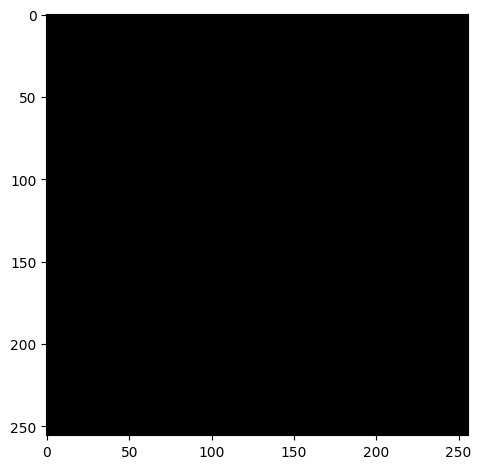

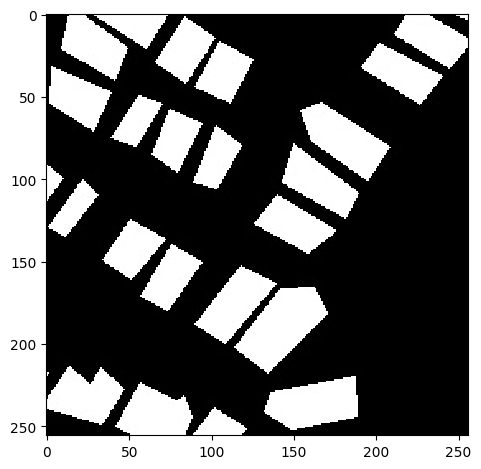

In [23]:
# show random images
import random
import matplotlib.pyplot as plt
import skimage.io as io
images_filenames = os.listdir("/kaggle/working/images/")

random_filename = random.choice(images_filenames) 

image = io.imread("/kaggle/working/images/"+random_filename)

# print(image)

io.imshow(image)
io.show()

label = io.imread("/kaggle/working/labels/"+random_filename)

io.imshow(label)
io.show()